# Random walker segmentation for Brain images

The random walker algorithm determines the segmentation of an image from a set of markers labeling several phases (2 or more). An anisotropic diffusion equation is solved with tracers initiated at the markers’ position. The local diffusivity coefficient is greater if neighboring pixels have similar values, so that diffusion is difficult across high gradients. The label of each unknown pixel is attributed to the label of the known marker that has the highest probability to be reached first during this diffusion process.

In this example, we try to segment a 2d input images for time saving purposes.

In [4]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib as mpl    
import matplotlib.ticker as ticker
import numpy as np
import math
from scipy.stats import norm
# for display
sub_size = 16
sup_size=20
if_plot = False

Load the input Image

In [5]:
dataFile = '../Data/brain.nii.gz'
maskFile = '../Data/brain_mask.nii'# Mask file, if any
brainImage = nib.load(dataFile).get_fdata()
maskImage = nib.load(maskFile).get_fdata()

slices = brainImage.shape[0]//2
img_slice = brainImage[slices]
seg_slice = maskImage[slices]

Visualize the data in axial, coronal and sagittal view.
Feel free to change the value of the array slices to see the different slices in axial, coronal and sagittal view.

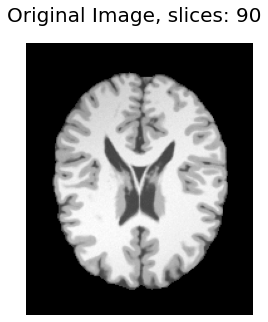

In [6]:
def plotOriginalImage(image, slices, title):
    fig = plt.figure(figsize=(5,5))
    fig.suptitle(title+', slices: ' + str(slices), fontsize=sup_size)
    plt.imshow(image, cmap='gray'); plt.axis('off')
    plt.show()

plotOriginalImage(img_slice, slices, title='Original Image')

Let's plot the image histogram to see if we can see some intensities peaks that will be fitted by our markers.

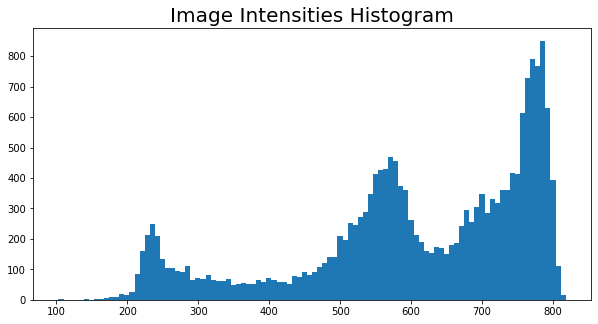

In [7]:
minIntensity = 100
mask = True
if mask:
    maskIndices = np.logical_and(np.array(seg_slice, dtype=np.bool_), img_slice > minIntensity)
    brainIntensities = img_slice[maskIndices]
else:
    maskIndices = img_slice > minIntensity
    brainIntensities = img_slice[img_slice > minIntensity]

plt.figure(figsize=(10, 5))
_ = plt.hist(brainIntensities.ravel(), bins=100) 
plt.title("Image Intensities Histogram", fontsize=sup_size)
plt.show()

If we look at the histogram of the image above, we can see that it has three peaks, most probably representing CSF, GM, and WM.

Now let's create our segmentation model. 
Feel free to change the values of the marker to see how the results change.

In [8]:
from skimage.segmentation import random_walker
from skimage.data import binary_blobs
from skimage.exposure import rescale_intensity
import skimage
import matplotlib.pyplot as plt

In [26]:
rng = np.random.default_rng()

# Generate noisy synthetic data
data = skimage.img_as_float(binary_blobs(length=128, seed=1))
sigma = 0.35
data += rng.normal(loc=0, scale=sigma, size=data.shape)
data = rescale_intensity(data, in_range=(-sigma, 1 + sigma),
                         out_range=(-1, 1))

# The range of the binary image spans over (-1, 1).
# We choose the hottest and the coldest pixels as markers.
markers = np.zeros(img_slice.shape, dtype=np.uint)
markers[img_slice < 100] = -1
markers[img_slice > 200] = 1; markers[img_slice > 400] = 0
markers[img_slice > 500] = 2; markers[img_slice > 600] = 0
markers[img_slice > 700] = 3; markers[img_slice > 800] = 0

# Run random walker algorithm
labels = random_walker(img_slice, markers, beta=10, mode='bf')


In [27]:
def plotSegmentation(labels, slices, if_plot=False):
    fig = plt.figure(figsize=(5,5))
    fig.suptitle('Segmentation Results', fontsize=sup_size)
    cmp = mpl.colors.ListedColormap(['k','b', 'gray', 'w'])
    img = plt.imshow(labels, cmap=cmp); plt.axis('off')    
    fig.subplots_adjust(right=0.9) # set width of the left three subplot equal to 0.9 
    # set the size of colorbar
    l=0.92; b=0.12; w=0.015; h=1-2*b #left, bottom, width, hight
    # set the position of colorbar
    rect = [l,b,w,h]
    cbar_ax = fig.add_axes(rect)
    cb1 = fig.colorbar(img, cax=cbar_ax)
    # set the scale of colobar
    tick_locator = ticker.MaxNLocator(nbins=3)
    cb1.locator = tick_locator
    cb1.set_ticks([0,1,2,3])
    for j, lab in enumerate(['BG','CSF','GM','WM']):
        cb1.ax.text(.5, (0.7*j + 0.5), lab, ha='center', va='center')
    cb1.update_ticks()
    plt.show()

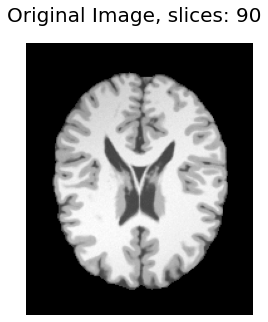

Label ID: [1 2 3 4]


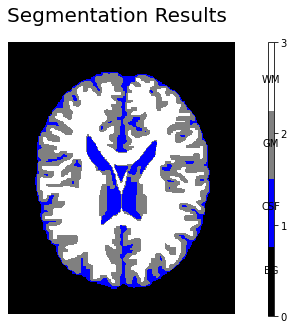

In [29]:
# Plot results
plotOriginalImage(img_slice, slices, title='Original Image')
print('Label ID:', np.unique(labels))
labels[labels==4]=0
plotSegmentation(labels, slices, if_plot=False)